# Linformer: Self-Attention with Linear Complexity

*Maxence Lasbordes, Jacques Maubert, Stanislas Boiton*

### Introduction:

Implementation of the Linformer self-attention and a vanilla transformer. Comparison of inference speed between the two models across various sequence lengths and projection dimensions.
Analysis of the hypothesis : Context mapping matrix is low rank.

In [1]:
import re
import time
import torch
import unicodedata
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from typing import List, Optional
import matplotlib.pyplot as plt
import numpy as np

### Vanilla Transformer layers (besides Selft-Attention)

In [2]:
class Embeddings(nn.Module):
    def __init__(self, vocab_size, d):
        super().__init__()
        embeddings = 0.02 * torch.randn(vocab_size, d)
        self.embeddings = nn.Parameter(embeddings)

    def forward(self, x):
        return self.embeddings[x]


class Linear(nn.Module):
    def __init__(self, d_in, d_out, bias=True):
        super().__init__()
        self.matrix = nn.Parameter(0.02 * torch.randn(d_in, d_out))
        if bias:
            self.bias = nn.Parameter(0.02 * torch.randn(d_out))

    def forward(self, x):
        results = x @ self.matrix
        if hasattr(self, "bias"):
            results += self.bias
        return results

def ReLU(x):
    return x * (x > 0)


class FeedForward(nn.Module):
    def __init__(self, d_embed, d_ff, dropout=0.1):
        super().__init__()
        self.w1 = Linear(d_embed, d_ff)  # usually d_ff >> d_embed
        self.w2 = Linear(d_ff, d_embed)
        self.act_fn = ReLU
        self.dropout = dropout

    def forward(self, x):
        z = self.w1(x)
        z = self.act_fn(z)
        z = F.dropout(z, p=self.dropout)
        z = self.w2(z)
        return z


class LayerNorm(nn.Module):
    def __init__(self, d, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(d))
        self.beta = nn.Parameter(torch.zeros(d))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

### Linformer Architecture (Self-Attention)

In [3]:
class LinformerMHA(nn.Module):
    def __init__(self, d_embed, n_heads, d_proj, max_length):
        super().__init__()
        self.d_proj = d_proj
        self.q_proj = nn.Linear(d_embed, d_embed, bias=False)
        self.k_proj = nn.Linear(d_embed, d_embed, bias=False)
        self.v_proj = nn.Linear(d_embed, d_embed, bias=False)

        self.E = nn.Linear(max_length, d_proj, bias=False)
        self.F = nn.Linear(max_length, d_proj, bias=False)

        assert (d_embed % n_heads) == 0
        self.n_heads = n_heads

    def forward(self, x, attention_mask):
        # d_proj = dimension of the low rank projection
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        
        batch_size, seq_len, d_embed = x.shape

        k_proj = self.E(k.transpose(1, 2)).transpose(1, 2) # (b, d_proj, d_embed)
        v_proj = self.F(v.transpose(1, 2)).transpose(1, 2) # (b, d_proj, d_embed)

        q = q.reshape(batch_size, seq_len, self.n_heads, -1).transpose(
            1, 2
        )  # (b, n_heads, seq_length, d_head)
        _, d_proj, _ = k_proj.shape
        k_proj = k_proj.reshape(batch_size, d_proj, self.n_heads, -1).transpose(1, 2)
        # (b, n_heads, d_proj, d_head)
        v_proj = v_proj.reshape(batch_size, d_proj, self.n_heads, -1).transpose(1, 2)
        # (b, n_heads, d_proj, d_head)
        s_ij = q @ k_proj.transpose(-1, -2)  # (b, n_heads, seq_length, d_proj)

        d = k_proj.shape[-1]
        s_ij = s_ij * (d**-0.5)

        attention_mask = 1.0 - attention_mask  # (b, seq_length)
        attention_mask = attention_mask.unsqueeze(1).unsqueeze(-1) # (b, 1, seq_length, 1)

        attention_mask = attention_mask.float() * (float("-inf"))  # (b, n_heads, seq_length, d_proj)
        s_ij = s_ij + attention_mask

        a_ij = torch.softmax(s_ij, dim=-1)
        y = a_ij @ v_proj  # (b, n_heads, seq_length, d_head)
        y = y.transpose(2, 1)

        y = y.reshape(batch_size, seq_len, d_embed) # concatenate
        return y

class LinformerLayer(nn.Module):
    def __init__(self, d_embed, d_ff, n_heads, d_proj, max_length, dropout=0.1):
        super().__init__()
        self.attention = LinformerMHA(d_embed, n_heads, d_proj, max_length)

        self.layer_norm_attention = LayerNorm(d_embed)
        self.layer_norm_feed_forward = LayerNorm(d_embed)

        self.dropout = dropout
        self.feed_forward = FeedForward(d_embed, d_ff, dropout=self.dropout)

    def forward(self, x, attention_mask):
        z = self.attention(x, attention_mask)
        z = F.dropout(z, p=self.dropout, training=self.training)
        z = z + x
        z = self.layer_norm_attention(z)

        y = self.feed_forward(z)
        y = y + z
        y = self.layer_norm_feed_forward(y)
        return y

class Linformer(nn.Module):
    def __init__(
        self,
        n_layers,
        d_embed,
        d_ff,
        n_heads,
        voc_size,
        max_length,
        d_proj,
        dropout=0.1,
    ):
        super().__init__()
        self.n_layers = n_layers
        self.d_embed = d_embed
        self.d_ff = d_ff
        self.num_heads = n_heads
        self.max_length = max_length
        self.voc_size = voc_size
        self.d_proj = d_proj
        self.dropout = dropout
        self.transformer_stack = nn.ModuleList(
            [LinformerLayer(
                d_embed=d_embed,
                d_ff=d_ff,
                n_heads=n_heads,
                d_proj=d_proj,
                max_length=max_length,
                dropout=self.dropout
            ) for _ in range(n_layers)]
        )


        self.token_embeddings = nn.Embedding(
            num_embeddings=self.voc_size, embedding_dim=self.d_embed
        )
        self.position_embeddings = nn.Embedding(
            num_embeddings=self.max_length, embedding_dim=self.d_embed
        )
        self.out_layer_norm = LayerNorm(self.d_embed)
        self.embedding_norm = LayerNorm(self.d_embed)
        self.lm_head = nn.Linear(self.d_embed, self.voc_size)

    def forward(self, input_ids, attention_mask):
        token_vectors = self.token_embeddings(input_ids)
        position_vectors = self.position_embeddings(
            torch.arange(input_ids.shape[-1], device=input_ids.device)
        )[None, :, :]
        z = token_vectors + position_vectors
        z = self.embedding_norm(z)
        for layer in self.transformer_stack:
            z = layer(z, attention_mask) + z
        y = self.out_layer_norm(z)
        logits = self.lm_head(y)
        return logits

### Transformer Architecture (Self-Attention)

In [4]:
class GPTMHAttention(nn.Module):
    def __init__(self, d_embed, n_heads):
        super().__init__()
        self.q_proj = nn.Linear(d_embed, d_embed, bias=False)
        self.k_proj = nn.Linear(d_embed, d_embed, bias=False)
        self.v_proj = nn.Linear(d_embed, d_embed, bias=False)

        assert (d_embed % n_heads) == 0
        self.n_heads = n_heads

    def forward(self, x, attention_mask):
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        batch_size, seq_len, d_embed = x.shape

        q = q.reshape(batch_size, seq_len, self.n_heads, -1).transpose(
            1, 2
        )
        k = k.reshape(batch_size, seq_len, self.n_heads, -1).transpose(1, 2)
        v = v.reshape(batch_size, seq_len, self.n_heads, -1).transpose(1, 2)
        s_ij = q @ k.transpose(-1, -2)

        d = k.shape[-1]
        s_ij = s_ij * (d**-0.5)

        attention_mask = 1.0 - attention_mask  # (b, seq_length)
        attention_mask = attention_mask.unsqueeze(1).unsqueeze(-1) # (b, 1, seq_length, 1)

        attention_mask = attention_mask.float() * (float("-inf"))  # (b, n_heads, seq_length, d_proj)
        s_ij = s_ij + attention_mask

        a_ij = torch.softmax(s_ij, dim=-1)
        y = a_ij @ v
        y = y.transpose(2, 1)

        y = y.reshape(batch_size, seq_len, d_embed)
        return y

class GPTMHTransformerLayer(nn.Module):
    def __init__(self, d_embed, d_ff, n_heads, dropout=0.1):
        super().__init__()
        self.attention = GPTMHAttention(d_embed, n_heads)

        self.layer_norm_attention = LayerNorm(d_embed)
        self.layer_norm_feed_forward = LayerNorm(d_embed)

        self.dropout = dropout
        self.feed_forward = FeedForward(d_embed, d_ff, dropout=self.dropout)

    def forward(self, x, attention_mask):
        z = self.attention(x, attention_mask)
        z = F.dropout(z, p=self.dropout, training=self.training)
        z = z + x
        z = self.layer_norm_attention(z)

        y = self.feed_forward(z)
        y = y + z
        y = self.layer_norm_feed_forward(y)
        return y

class GPTTransformer(nn.Module):
    def __init__(
        self,
        n_layers,
        d_embed,
        d_ff,
        n_heads,
        voc_size,
        max_length,
        dropout=0.1,
    ):
        super().__init__()
        self.n_layers = n_layers
        self.d_embed = d_embed
        self.d_ff = d_ff
        self.num_heads = n_heads
        self.max_length = max_length
        self.voc_size = voc_size
        self.dropout = dropout
        self.transformer_stack = nn.ModuleList(
            [GPTMHTransformerLayer(
                d_embed=d_embed,
                d_ff=d_ff,
                n_heads=n_heads,
                dropout=self.dropout
            ) for _ in range(n_layers)]
        )


        self.token_embeddings = nn.Embedding(
            num_embeddings=self.voc_size, embedding_dim=self.d_embed
        )
        self.position_embeddings = nn.Embedding(
            num_embeddings=self.max_length, embedding_dim=self.d_embed
        )
        self.out_layer_norm = LayerNorm(self.d_embed)
        self.embedding_norm = LayerNorm(self.d_embed)
        self.lm_head = nn.Linear(self.d_embed, self.voc_size)

    def forward(self, input_ids, attention_mask):
        token_vectors = self.token_embeddings(input_ids)
        position_vectors = self.position_embeddings(
            torch.arange(input_ids.shape[-1], device=input_ids.device)
        )[None, :, :]
        z = token_vectors + position_vectors
        z = self.embedding_norm(z)
        for layer in self.transformer_stack:
            z = layer(z, attention_mask) + z
        y = self.out_layer_norm(z)
        logits = self.lm_head(y)
        return logits

### Loading the Dataset, the Tokenizer and building the pipeline

In [5]:
%pip install datasets
from datasets import load_dataset

Note: you may need to restart the kernel to use updated packages.


In [6]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


In [7]:
class WhiteSpaceTokenizer:
    def __init__(self, max_voc: Optional[int] = None, max_length: int = 512):
        self.vocab = {}
        self.id_to_token = {}
        self.frequencies = {}
        self.max_voc = max_voc
        self.max_length = max_length

    def split_text(self, text: str) -> List[str]:
        """Converts the text to a list of tokens (substrings)."""
        return text.split(" ")

    def encode(self, text: str) -> List[int]:
        """Take a text as input and return its associated tokenization, as a list of ids."""
        list_tokens = self.split_text(text)
        list_ids = []
        unknown_id = self.vocab["<UNK>"]
        for token in list_tokens:
            list_ids.append(self.vocab.get(token, unknown_id))
        list_ids = list_ids[: self.max_length - 2]
        list_ids = [self.vocab["<BOS>"]] + list_ids + [self.vocab["<EOS>"]]
        return list_ids

    def decode(self, ids: List[int]) -> str:
        tokens = [self.id_to_token[i] for i in ids]
        return " ".join(tokens)

    def add_special_token(self, token: str):
        """Add a special token to the vocabulary."""
        if token not in self.vocab:
            self.vocab[token] = len(self.vocab)
            self.id_to_token[len(self.id_to_token)] = token

    def fit(self, corpus: List[str]):
        """Fits the tokenizer to a list of texts to construct its vocabulary."""
        for text in tqdm(corpus):
            list_tokens = self.split_text(text)
            for token in list_tokens:
                token_count = self.frequencies.get(token, None)
                if token_count is None:
                    self.frequencies[token] = 0

                self.frequencies[token] += 1
        if self.max_voc is not None:
            self.frequencies = sorted(
                self.frequencies.items(), key=lambda x: x[1], reverse=True
            )
            self.frequencies = dict(self.frequencies[: self.max_voc])
        for i, token in enumerate(self.frequencies):
            self.vocab[token] = i
            self.id_to_token[i] = token
        self.num_words = len(self.vocab)
        self.add_special_token("<UNK>")
        self.add_special_token("<BOS>")
        self.add_special_token("<EOS>")
        print(f"Built a vocabulary of {self.num_words} words.")

In [8]:
def preprocess_text(text: str) -> str:
    # lower case
    text = text.lower()

    # string normalization.
    text = unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode()
    text = text.replace("<br />", "")

    # Add whitespace around punctuation marks (., !)
    text = re.sub(r"([.!,?])", r" \1 ", text)

    # Remove any extra spaces that may have been added
    text = re.sub(r"\s+", " ", text).strip()

    #  remove non alpha numeric characters.
    text = re.sub(r"[^a-zA-Z0-9\s.!,]", " ", text)

    # replace numbers by the <NUM> token.
    text = re.sub(r"\d+", "<NUM>", text)

    # remove double whitespaces.
    text = re.sub(" +", " ", text.strip())

    #  remove br tags
    return text


# Clean the dataset
dataset = dataset.map(lambda x: {"text": preprocess_text(x["review"])})

In [9]:
tokenizer = WhiteSpaceTokenizer(max_voc=10000)
tokenizer.fit(dataset["text"])
tokenizer.add_special_token("<PAD>")

  0%|          | 0/50000 [00:00<?, ?it/s]

Built a vocabulary of 10000 words.


In [10]:
def preprocessing_fn(x, tokenizer):
    x["input_ids"] = tokenizer.encode(x["text"])
    return x

In [11]:
class DataCollator:
    def __init__(self, pad_token_id: int, label_pad_token_id: int = -100, max_length: int = 512):
        self.pad_token_id = pad_token_id
        self.label_pad_token_id = label_pad_token_id
        self.max_length = max_length

    def __call__(self, batch):
        # max_label_length = max(len(f["input_ids"]) for f in batch)
        for feature in batch:
            input_ids = feature["input_ids"]
            label_ids = feature["input_ids"]
            current_length = len(input_ids)

            input_remainder = [
                self.pad_token_id for _ in range(self.max_length - current_length)
            ]
            input_ids = input_ids + input_remainder

            label_remainder = [
                self.label_pad_token_id
                for _ in range(self.max_length - current_length)
            ]
            labels = label_ids + label_remainder
            feature["input_ids"] = input_ids
            feature["labels"] = labels
            feature["attention_mask"] = [1 for _ in range(current_length)] + [
                0 for _ in range(self.max_length - current_length)
            ]
        features = {
            "input_ids": torch.tensor([f["input_ids"] for f in batch]),
            "attention_mask": torch.tensor([f["attention_mask"] for f in batch]),
            "labels": torch.tensor([f["labels"] for f in batch]),
        }
        return features

### Initialize the two models

In [12]:
model_linformer = Linformer(
    d_embed=256,
    d_ff=1024,
    n_heads=4,
    n_layers=1,
    voc_size=len(tokenizer.vocab),
    max_length=512,
    d_proj=128,
    dropout=0.1,
)

model_transformer = GPTTransformer(
    d_embed=256,
    d_ff=1024,
    n_heads=4,
    n_layers=1,
    voc_size=len(tokenizer.vocab),
    max_length=512,
    dropout=0.1,
)

### Compute and compare Inference Time

In [13]:
n_samples = 128

dataset = dataset.shuffle()

splitted_dataset = dataset.select(range(n_samples))

splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)

splitted_dataset = splitted_dataset.select_columns(["input_ids"])

inference_set = splitted_dataset
print(len(inference_set['input_ids']))

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

128


In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_linformer = model_linformer.to(DEVICE)
model_transformer = model_transformer.to(DEVICE)

data_collator = DataCollator(pad_token_id=tokenizer.vocab["<PAD>"])
batch_size = 128

inference_dataloader = DataLoader(
    inference_set, batch_size=batch_size, collate_fn=data_collator
)


def count_parameters(model: nn.Module):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return f"{total_params:,}"

# Parameters of the 2 models
print("Linformer Model:\n")
print("Model size:", count_parameters(model_linformer))

print("\nTransformer Model:\n")
print("Model size:", count_parameters(model_transformer))

Linformer Model:

Model size: 6,118,420

Transformer Model:

Model size: 5,987,348


In [15]:
def inference_test(
    model,
    train_dataloader: DataLoader,
):
    model.to(DEVICE)  # Move model to the appropriate device
    model.eval()
    with torch.no_grad():
        for batch in tqdm(train_dataloader, desc="Inference"):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            input_ids, attention_mask, labels = (
                batch["input_ids"],
                batch["attention_mask"],
                batch["labels"],
            )

            _ = model(input_ids, attention_mask)
    return


In [16]:
start = time.time()
inference_time_linformer = inference_test(model_linformer, inference_dataloader)
end = time.time()
print(f"Linformer inference time: {end - start:.4f} s")

start = time.time()
inference_time_transformer = inference_test(model_transformer, inference_dataloader)
end = time.time()
print(f"\nTransformer inference time: {end - start:.4f} s")

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Linformer inference time: 0.8132 s


Inference:   0%|          | 0/1 [00:00<?, ?it/s]


Transformer inference time: 0.1128 s


### Results


To compute those inference times, we used the previous code multiple times with various batch sizes and sequence lengths.

We also need to change the Tokenizer max_length and the DataCollator max_length each time, to the same value as the max_length of the models.

We couldn't go further than a sequence length of 8192, because of computational limitations.

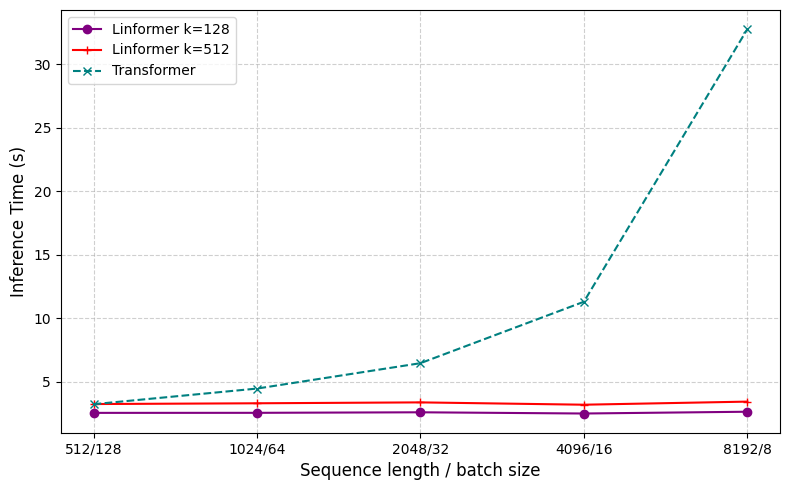

In [17]:
seq_batch = ['512/128', '1024/64', '2048/32', '4096/16', '8192/8']
linformer_128 = [2.5606, 2.5641, 2.6062, 2.5106, 2.6504]
linformer_512 = [3.2546, 3.3152, 3.3859, 3.2027, 3.4462]
transformer = [3.2429, 4.4726, 6.4692, 11.3022, 32.7407]

plt.figure(figsize=(8, 5))
plt.plot(seq_batch, linformer_128, label='Linformer k=128', marker='o', color='purple')
plt.plot(seq_batch, linformer_512, label='Linformer k=512', marker='+', color='red')
plt.plot(seq_batch, transformer, label='Transformer', marker='x', linestyle='--', color='teal')
plt.xlabel('Sequence length / batch size', fontsize=12)
plt.ylabel('Inference Time (s)', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Analysis of the Self attention is low rank hypothesis

In [18]:
INF = 1e10

class contextmapping(nn.Module):
    def __init__(self, d):
        super().__init__()

        self.q_proj = Linear(d, d)
        self.k_proj = Linear(d, d)
        self.v_proj = Linear(d, d)

    def forward(self, x):
        q = self.q_proj(x)  # (b, l, d)
        k = self.k_proj(x)

        d = k.shape[-1]
        s_ij = q @ k.transpose(1, 2) * d ** (-0.5)  # (b, l, l)

        a_ij = torch.softmax(s_ij, dim=-1)
        return a_ij

class contextmappingwithoutdata(nn.Module):
    def __init__(self, d):
        super().__init__()

        self.q_proj = Linear(d, d)
        self.k_proj = Linear(d, d)

    def forward(self, x, y):
        q = self.q_proj(x)  # (b, l, d)
        k = self.k_proj(y)

        d = k.shape[-1]
        s_ij = q @ k.transpose(1, 2) * d ** (-0.5)  # (b, l, l)

        a_ij = torch.softmax(s_ij, dim=-1)
        return a_ij


## Analysis for a max lenght of 512

In [19]:
for batch in inference_dataloader:
    input = batch['input_ids'][0]
    break
print(input.shape)

torch.Size([512])


In [20]:
d_embed = 256
d_ff = 1024
gauss_input = torch.randn([1, 512, 256])
poisson_input = torch.poisson(torch.full((1, 512, 256), 3.))
embedding = Embeddings(len(tokenizer.vocab), d_embed)
embed_input = 50*embedding(input).unsqueeze(0) #since the embedding mapping was generating using a scaler factor 0.02, we cancel it with the factor 50 unless our ouptut would be too small
cm = contextmapping(d_embed)
out_gauss = cm(gauss_input)[0]
out_imdb = cm(embed_input)[0]
out_poisson = cm(poisson_input)[0]
print(out_gauss.shape)

torch.Size([512, 512])


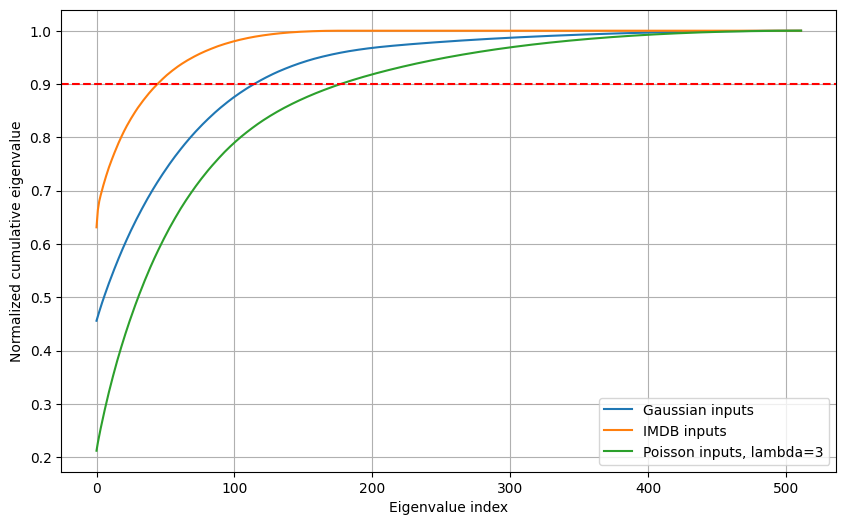

In [21]:
plt.figure(figsize=(10, 6))
_,S_gauss,_ = np.linalg.svd(out_gauss.detach().numpy())
plt.plot(np.cumsum(S_gauss)/np.sum(S_gauss), label = "Gaussian inputs")
_,S_imdb,_ = np.linalg.svd(out_imdb.detach().numpy())
plt.plot(np.cumsum(S_imdb)/np.sum(S_imdb), label = "IMDB inputs")
_,S_poisson,_ = np.linalg.svd(out_poisson.detach().numpy())
plt.plot(np.cumsum(S_poisson)/np.sum(S_poisson), label = "Poisson inputs, lambda=3")
plt.legend()
plt.xlabel('Eigenvalue index')
plt.ylabel('Normalized cumulative eigenvalue')
plt.axhline(y=0.90, color='r', linestyle='--')
plt.grid()
plt.show()

In [22]:
d_embed = 256
d_ff = 1024
gauss_input = torch.randn([1, 4096, 256])
poisson_input = torch.poisson(torch.full((1, 4096, 256), 3.))
out_gauss = cm(gauss_input)[0]
out_poisson = cm(poisson_input)[0]
print(out_gauss.shape)

torch.Size([4096, 4096])


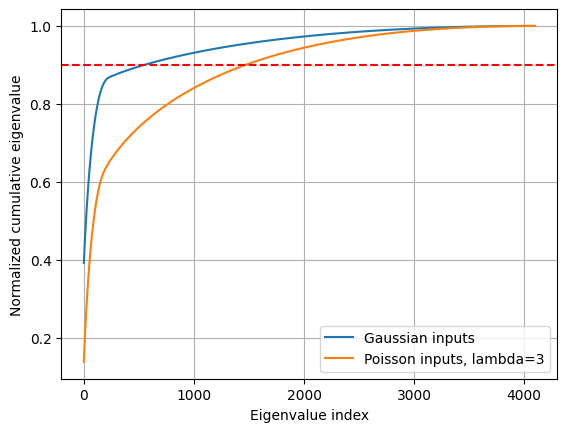

In [23]:
_,S_gauss,_ = np.linalg.svd(out_gauss.detach().numpy())
plt.plot(np.cumsum(S_gauss)/np.sum(S_gauss), label = "Gaussian inputs")
_,S_poisson,_ = np.linalg.svd(out_poisson.detach().numpy())
plt.plot(np.cumsum(S_poisson)/np.sum(S_poisson), label = "Poisson inputs, lambda=3")
plt.legend()
plt.xlabel('Eigenvalue index')
plt.ylabel('Normalized cumulative eigenvalue')
plt.axhline(y=0.90, color='r', linestyle='--')
plt.grid()
plt.show()